# Classificador de Fake News e proposta para não-proliferação das mesmas

   O assunto de Fake News está em alta na mídia já a um bom tempo, e teve seu pico quando o presidente dos Estados Unidos, Donald Trump, com a sua conta de Twitter, começou a disseminar a palavra sobre supostos sites de notícias que lançavam "notícias falsas". Tendo em mente isso, visamos a criar um programa utilizando de Machine Learning que faz o trabalho de decidir, utilizando a base de Natural Language Processing (NLP), se uma notícia realmente é falsa ou não. Para isso, este Notebook estará dividido nas seguintes partes: 
  - Pré-Processamento
  - Análise Exploratória dos Dados
  - Aplicação do Modelo de Machine Learning 
  - Validação e conclusão do Modelo

## Importação de libraries e de dados

In [147]:
import pandas as pd
import numpy as np
import seaborn as sb
import simplejson
import matplotlib.pyplot as plt
import re
from tqdm import tqdm 
from goose3 import Goose
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer 
from gensim.models.tfidfmodel import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [2]:
# Importamos uma certa quantia de dados do nosso arquivo json.

data_raw = []
num_data = 2000
with open('data/fake-news-tera.json') as file:
    for i in tqdm(range(num_data)):
        line = next(file)
        data_raw.append(simplejson.loads(line))
        
df_raw = pd.DataFrame(data_raw)

100%|██████████| 2000/2000 [00:00<00:00, 4162.32it/s]


## Pré-processamento

In [3]:
# Primeira olhada nos nossos dados

df_raw.head()

,app,content,date,location_city,location_country,location_lat,location_lng,location_state,profile_avatar,profile_description,...,profile_location,profile_login,profile_name,profile_url,profile_web,related_tweet_content,related_tweet_date,related_tweet_url,source,url
0,Facebook,Veja o passo a passo: http://fb.me/CK6knq9W,2017-10-31T06:00:03.000Z,Brás de Pina,Brasil,-22.832979,-43.297668,Rio de Janeiro,https://pbs.twimg.com/profile_images/339749594...,"Em breve, o melhor GUIA TURÍSTICO do Rio | Soo...",...,Rio de Janeiro (BR),amigonorio,Amigo no Rio,https://twitter.com/amigonorio,http://www.amigonorio.com.br,None,None,None,0,https://twitter.com/608352107/statuses/9252409...
1,Twitter for iPhone,@maika_1020 BAND MAIDのchoose me(｡>人<),2017-11-01T05:59:13.000Z,None,None,NaN,NaN,None,https://pbs.twimg.com/profile_images/920977346...,MOSHIMO SILENT SIREN sevenoops,...,None,msyn_711,まっしゃん,https://twitter.com/msyn_711,None,None,None,None,0,https://twitter.com/621782721/statuses/9256031...
2,Twitter Web Client,"É DONO DO STF. ONDE TODOS SÃO COVARDES, CONFOR...",2017-11-01T06:00:04.000Z,None,Brasil,-10.000000,-55.000000,None,https://pbs.twimg.com/profile_images/919944565...,"QUANDO OS QUE COMANDAM PERDEM A VERGONHA,OS CO...",...,Brasil,CarlitoMoraes,Carlito Moraes,https://twitter.com/CarlitoMoraes,None,Absurdo ... Gilmar se sente o dono do Brasil ....,2017-10-31T14:19:45.000Z,https://twitter.com/887707008/statuses/9253666...,0,https://twitter.com/346220548/statuses/9256033...
3,Twitter Lite,porra a globo corta se fodrrrr,2017-11-03T05:59:52.000Z,Santos,Brasil,-23.856630,-46.270550,São Paulo,https://pbs.twimg.com/profile_images/925930977...,musa de Alceu Valença•\n@justinbieber💙,...,baixada santista,ingcarvalh0,dindi,https://twitter.com/ingcarvalh0,https://www.instagram.com/morena7ropicana/?hl=...,None,None,None,0,https://twitter.com/1315339214/statuses/926328...
4,Twitter Lite,@UOL Deviam ter deixado mata-lo,2017-11-05T05:58:10.000Z,None,None,NaN,NaN,None,https://pbs.twimg.com/profile_images/905322029...,enfrentando novos desafios e vivendo um dia de...,...,None,wall2013,wall2013,https://twitter.com/wall2013,http://walterdesouza2012.blogspot.com.br/,None,None,None,0,https://twitter.com/1172898380/statuses/927052...


In [4]:
# Para nossa análise, foi concluído que não precisamos de algumas das colunas de nosso DataFrame, então foram tiradas:

df_clean = df_raw.drop(['app', 'location_city', 'location_country', 'location_lat', 'location_lng', 'location_state', 'profile_avatar', 'profile_location', 'profile_name', 'profile_web', 'related_tweet_date'], axis=1)
df_clean.head()

,content,date,profile_description,profile_followers,profile_following,profile_login,profile_url,related_tweet_content,related_tweet_url,source,url
0,Veja o passo a passo: http://fb.me/CK6knq9W,2017-10-31T06:00:03.000Z,"Em breve, o melhor GUIA TURÍSTICO do Rio | Soo...",18.0,15.0,amigonorio,https://twitter.com/amigonorio,None,None,0,https://twitter.com/608352107/statuses/9252409...
1,@maika_1020 BAND MAIDのchoose me(｡>人<),2017-11-01T05:59:13.000Z,MOSHIMO SILENT SIREN sevenoops,695.0,674.0,msyn_711,https://twitter.com/msyn_711,None,None,0,https://twitter.com/621782721/statuses/9256031...
2,"É DONO DO STF. ONDE TODOS SÃO COVARDES, CONFOR...",2017-11-01T06:00:04.000Z,"QUANDO OS QUE COMANDAM PERDEM A VERGONHA,OS CO...",5694.0,4225.0,CarlitoMoraes,https://twitter.com/CarlitoMoraes,Absurdo ... Gilmar se sente o dono do Brasil ....,https://twitter.com/887707008/statuses/9253666...,0,https://twitter.com/346220548/statuses/9256033...
3,porra a globo corta se fodrrrr,2017-11-03T05:59:52.000Z,musa de Alceu Valença•\n@justinbieber💙,2641.0,1098.0,ingcarvalh0,https://twitter.com/ingcarvalh0,None,None,0,https://twitter.com/1315339214/statuses/926328...
4,@UOL Deviam ter deixado mata-lo,2017-11-05T05:58:10.000Z,enfrentando novos desafios e vivendo um dia de...,159.0,953.0,wall2013,https://twitter.com/wall2013,None,None,0,https://twitter.com/1172898380/statuses/927052...


In [5]:
# Vemos o shape de nossos dados e suas características

print('Shape:\n')
print(df_clean.shape)
print(10*'-')
print('Contagem de NaN:\n')
print(df_clean.isna().sum())
print(10*'-')
print('Contagem de Null:\n')
print(df_clean.isnull().sum())
print(10*'-')

Shape:

(2000, 11)
----------
Contagem de NaN:

content                     0
date                        0
profile_description       416
profile_followers          35
profile_following          35
profile_login               0
profile_url                 0
related_tweet_content    1781
related_tweet_url        1781
source                      0
url                         0
dtype: int64
----------
Contagem de Null:

content                     0
date                        0
profile_description       416
profile_followers          35
profile_following          35
profile_login               0
profile_url                 0
related_tweet_content    1781
related_tweet_url        1781
source                      0
url                         0
dtype: int64
----------


Quando analisamos os dados acima, podemos ver que aproximadamente 90% dos dados não tem 'related_tweet_content', porém não é bom tira-los do nosso dataset, pois é um dos lugares aonde é possível puxar a URL da notícia que queremos.

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

In [6]:
# Para que possamos analisar as notícias mencionadas nos tweets em nosso dataset, precisamos da URL da mesma
# Assim, criamos uma função para receber uma STRING e retornar o link contido na mesma. Caso não haja, retorna None

def find_url(raw):
    if raw == None:
        return None
    txt = re.search('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', raw)
    if txt:
        return txt.group()
    else:
        return None

In [7]:
# E então, analisando os dados, vimos que o link para a notícia pode estar tanto na coluna 'content' quanto na de
# 'related_tweet_content', portanto para criar a coluna 'URL', contento as URL que posteriormente tem que ser ana-
# lisadas, checamos primeiramente se há na 'related_tweet_content', depois no 'content', se existirem

df_clean['URL'] = None # Coluna de URL, que será atualizada 
for i in tqdm(range(num_data)):
    cont = find_url(df_clean['content'][i])
    re_cont = find_url(df_clean['related_tweet_content'][i])
    if find_url(str(re_cont)) != None:
        df_clean.loc[i, 'URL'] = re_cont
    elif cont != None:
        df_clean.loc[i, 'URL'] = cont
    else:
        df_clean.loc[i, 'URL'] = None

df_clean['URL'].head() # Verificação do output

100%|██████████| 2000/2000 [00:01<00:00, 1274.66it/s]


0       http://fb.me/CK6knq9W
1                        None
2    http://ow.ly/boor30gfBli
3                        None
4                        None
Name: URL, dtype: object

In [8]:
# Agora, de cada URL precisamos pegar o corpo do texto. Para nossa sorte, a biblioteca goose3 tem um módulo que 
# faz exatamente isso para nós. :) 
# Note que esse processo é demorado. 

df_clean['Article'] = None
g = Goose()
for i in tqdm(range(num_data)):
    url = df_clean.loc[i, 'URL']
    if not(url):
        df_clean.loc[i, 'Article'] = None
    else:
        try:
            article = g.extract(url=url)
            df_clean.loc[i, 'Article'] = article.cleaned_text
        except:
            df_clean.loc[i, 'Article'] = None

 18%|█▊        | 369/2000 [03:34<15:49,  1.72it/s]File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/9c750a55e03b665c570d63f1a554c6e4.1512875986.9936242_193e86f76a27012d6904aaacc8290000'>
File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/9c750a55e03b665c570d63f1a554c6e4.

File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/54f3de9b31536d8fadaaf1f78b052653.1512876568.580545_c44a81345955a4a84e454ea8cabe0c74'>
File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/54f3de9b31536d8fadaaf1f78b052653.1512876568.580545_ad1ef89fcdc41b1657f6958aef958fdd'

 77%|███████▋  | 1540/2000 [18:43<05:35,  1.37it/s]File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/c57007ecb3f7f25b56a95e5d8719c660.1512876896.096476_223abc5c8ce203ed9bb389a7bb490f2d'>
File not found
Traceback (most recent call last):
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/goose3/utils/images.py", line 44, in get_image_dimensions
    with Image.open(img_file) as image:
  File "/home/marcello/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2319, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='/tmp/goose/c57007ecb3f7f25b56a95e5d8719c660.

In [14]:
## Confirmamos nossa nova coluna
print(df_clean['Article'][:10])

0    O WhatsApp começou a liberar há alguns dias a ...
1                                                 None
2    É a primeira decisão de Gilmar após o desenten...
3                                                 None
4                                                 None
5    O índice de desemprego nos Estados Unidos caiu...
6                                                 None
7    Uma estudante surda de Santos, no litoral de S...
8                                                 None
9                                                 None
Name: Article, dtype: object


In [21]:
# Como no português temos muitos caracteres especiais, precisamos normaliza-los.

for i in tqdm(range(num_data)):
    text = df_clean.loc[i, 'Article']
    if text:
        nfkd_form = unicodedata.normalize('NFKD', text)
        only_ascii = nfkd_form.encode('ASCII', 'ignore')
        df_clean.loc[i, 'Article'] = only_ascii.decode('utf-8')

100%|██████████| 2000/2000 [00:00<00:00, 7063.29it/s]


In [22]:
# Testamos novamente nosso dataset 

print(df_clean['Article'][:10])

0    O WhatsApp comecou a liberar ha alguns dias a ...
1                                                 None
2    E a primeira decisao de Gilmar apos o desenten...
3                                                 None
4                                                 None
5    O indice de desemprego nos Estados Unidos caiu...
6                                                 None
7    Uma estudante surda de Santos, no litoral de S...
8                                                 None
9                                                 None
Name: Article, dtype: object


In [130]:
# Nisso, fazemos o pré-processamento do texto em uma função

def preprocessing_nlp(df_clean):
    letters_only = ''
    for i in tqdm(range(num_data)):
        txt = df_clean.loc[i, 'Article']
        if txt:
            letters_only = str(letters_only)+' '+str(re.sub("\W+",           # The pattern to search for
                                  " ",                   # The pattern to replace it with
                                  df_clean.loc[i,'Article']))  # The text to search
    lower_case = letters_only.lower()
    rmv_whitespace = lower_case.strip()
    words = rmv_whitespace.split()
    words = [w for w in words if not w in stopwords.words("portuguese") and w]
    stemming = SnowballStemmer("portuguese")
    words_stem = [stemming.stem(t) for t in words]
    return words_stem

#E então, testamos a função e vemos as palavras mais faladas

procs_words = preprocessing_nlp(df_clean)
print(procs_words[:10])
counter = Counter(procs_words)
print(counter.most_common(10))


100%|██████████| 2000/2000 [00:00<00:00, 10712.63it/s]

['whatsapp', 'comec', 'liber', 'ha', 'alguns', 'dias', 'ferrament', 'permit', 'apag', 'mensag']
[('nao', 1138), ('ser', 471), ('pod', 359), ('president', 342), ('sao', 320), ('tamb', 315), ('tod', 314), ('cas', 308), ('part', 292), ('segund', 272)]


In [131]:
## Agora faremos o processo de Bag of Words

def prepare_bow(wrds):
    docs = [doc.split() for doc in wrds]
    dictionary = Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return corpus, dictionary

# Testamos :) 

bow, dictionary = prepare_bow(procs_words)
print(bow[:5])

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)]]


In [133]:
# Agora iremos fazer o nosso CountVectorizer, para posteriormente podermos colocar em um modelo. Assim, acabamos 
# nossa parte de pré-processamento até o ponto de CountVectorizer! :) 

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)  
train = vectorizer.fit(procs_words)
train.vocabulary_

{'whatsapp': 4967,
 'comec': 1069,
 'liber': 2674,
 'ha': 2226,
 'alguns': 405,
 'dias': 1510,
 'ferrament': 1971,
 'permit': 3486,
 'apag': 518,
 'mensag': 2922,
 'envi': 1754,
 'amig': 461,
 'recurs': 3935,
 'promet': 3762,
 'ser': 4288,
 'util': 4792,
 'usuari': 4788,
 'encaminh': 1702,
 'algum': 404,
 'conteud': 1213,
 'errad': 1766,
 'arrepend': 585,
 'ter': 4570,
 'dit': 1564,
 'algo': 401,
 'log': 2730,
 'apos': 537,
 'novidad': 3164,
 'funcion': 2080,
 'tant': 4524,
 'versa': 4869,
 'android': 485,
 'iphon': 2489,
 'enquant': 1727,
 'necessari': 3101,
 'estar': 1820,
 'usand': 4779,
 'bet': 751,
 'part': 3393,
 '17': 37,
 '400': 129,
 'sistem': 4358,
 'googl': 2177,
 'aind': 366,
 'assim': 610,
 'funca': 2079,
 'send': 4275,
 'gradual': 2188,
 'pod': 3570,
 'demor': 1412,
 'cheg': 983,
 'tod': 4615,
 'celul': 937,
 'conf': 1142,
 'nest': 3119,
 'tutorial': 4728,
 'olhar': 3234,
 'digital': 1520,
 'temp': 4557,
 'maxim': 2886,
 'set': 4307,
 'minut': 2982,
 'la': 2602,
 'text': 

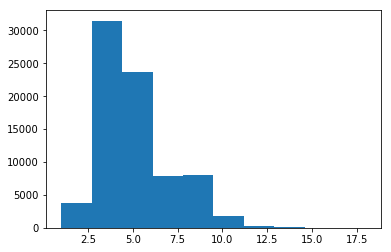

In [167]:
# Vejamos a distribuição de tamanho de palavras 

plt.hist([len(procs_words[i]) for i in range(len(procs_words))], 10)
plt.show()